In [ ]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from google.colab import drive
from datetime import datetime

In [ ]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/KU/Robin_lab_project' 
os.chdir(root_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set details for saving the plots
DIRECTORY = "Plots/all_replicate/"
FILENAME = "all_replicate_negFiltered"

# Data exploration

In [ ]:
# Load data 
profiles_all = pd.read_csv("Data/ML_input/profiles_all_replicate_negfiltered.csv")
metadata_all = pd.read_csv("Data/ML_input/metadata_all_replicate_negfiltered.csv")

X = profiles_all.drop("label", axis=1)
X = StandardScaler().fit_transform(X)
y = profiles_all["label"]

print(X.shape)
print(y.shape)

(32168, 1002)
(32168,)


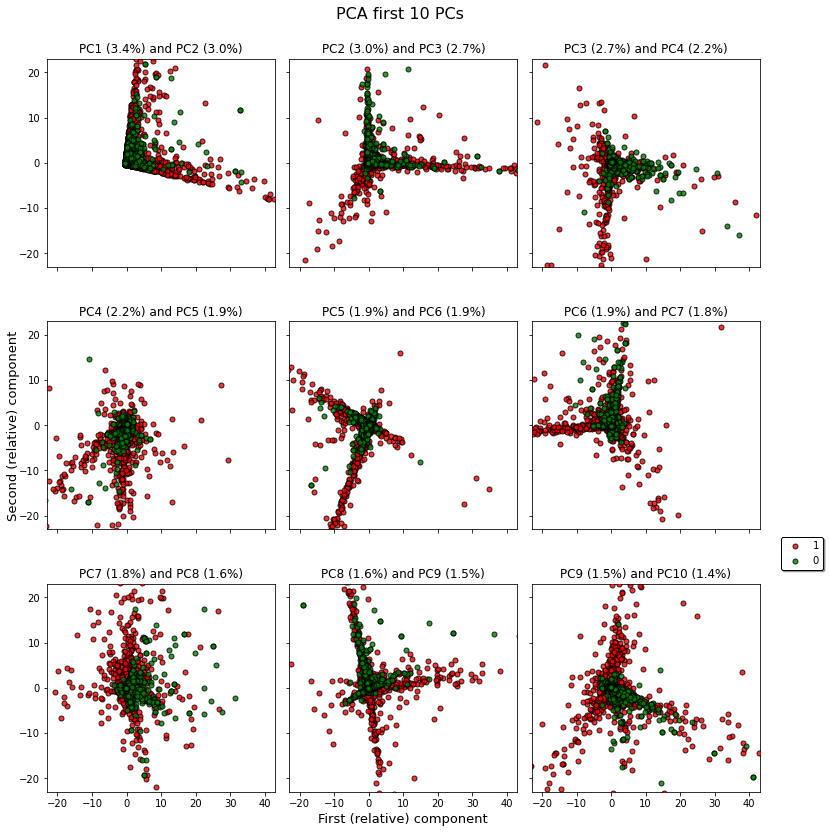

In [ ]:
#  PCA plot
def multi_plot_pca(x, y, 
                   nrows=2, xlim=(-23,43), ylim=(-23,23),
                   figsize=(12,7), top=0.89,
                   title="", save=False, filename="pca"):
  # Perform PCA and MDS
  n_pcs = nrows*3+1
  pca = PCA(n_components=n_pcs)
  pcs = pca.fit_transform(x)
  var = pca.explained_variance_ratio_ * 100
  tmp_df = pd.concat([pd.DataFrame(pcs), y], axis = 1)
  targets = [1,0]
  colors = ["r","g"]
  # Plot fig and axes
  fig, axes = plt.subplots(nrows, 3, figsize = figsize, sharex=True, sharey=True)
  fig.add_subplot(111, frameon=False)
  for target, color in zip(targets,colors):
    i_keep = tmp_df['label'] == target
    for i ,ax in enumerate(axes.flatten()):
      ax.scatter(tmp_df.loc[i_keep,i], tmp_df.loc[i_keep,i+1], zorder=3, 
                      ec="black", c=color, s=25, alpha = 0.8, label = target) 
      ax.set_title(f"PC{i+1} ({var[i]:.2}%) and PC{i+2} ({var[i+1]:.2}%)")
      ax.set_xlim(xlim)
      ax.set_ylim(ylim)
  # Details
  legend = ax.legend(frameon = 1, shadow = True, bbox_to_anchor=(1.3, 1.25))
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
  fig.suptitle(f"PCA first {n_pcs} PCs{title}", fontsize=16)
  plt.xlabel("First (relative) component", fontsize=13)
  plt.ylabel("Second (relative) component", fontsize=13)
  fig.tight_layout()
  fig.subplots_adjust(top=top)
  if save == True:
      plt.savefig(f"{filename}.png", dpi = 300)
  plt.show()

multi_plot_pca(X, y, nrows=3, figsize=(12,12), top=0.92, 
               save=True, filename=f"{DIRECTORY}pca_multiplot_{FILENAME}")     

# Models development

### Split train and test by chromosomes number

In [ ]:
# Load data divded by chr number
profiles_train = pd.read_csv("Data/ML_input/profiles_all_replicate_negfiltered_train.csv")
profiles_test = pd.read_csv("Data/ML_input/profiles_all_replicate_negfiltered_test.csv")
metadata_train = pd.read_csv("Data/ML_input/metadata_all_replicate_negfiltered_train.csv")
metadata_test = pd.read_csv("Data/ML_input/metadata_all_replicate_negfiltered_test.csv")

# Divide predictor and target
X_TRAIN = profiles_train.drop("label", axis = 1)
y_TRAIN = profiles_train["label"]
X_TEST = profiles_test.drop("label", axis = 1)
y_TEST = profiles_test["label"]

# # Normalization
# scaler = StandardScaler()
# X_TRAIN = scaler.fit_transform(X_TRAIN)
# X_TEST = scaler.transform(X_TEST)

print(X_TRAIN.shape)
print(y_TRAIN.shape)
print(X_TEST.shape)
print(y_TEST.shape)

(26346, 1002)
(26346,)
(5822, 1002)
(5822,)


In [ ]:
def get_accuracy(ypred, y):
  return sum(ypred == y) / len(y)

def get_rmse(yprob, y):
  return np.sqrt(np.mean((yprob-y)**2))


Randomly split TRAIN into train and validation keeping labels proportion (used as faster validation in alternative to CV)

In [ ]:
# Split training set into train and validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20)
sss.split(X_TRAIN, y_TRAIN)

for itrain, ival in sss.split(X_TRAIN, y_TRAIN):
  X_train, X_val = X_TRAIN.iloc[itrain], X_TRAIN.iloc[ival]
  y_train, y_val = y_TRAIN[itrain], y_TRAIN[ival]

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(21076, 1002)
(21076,)
(5270, 1002)
(5270,)


Subset the data for fast testing

In [ ]:
# # Use reduced size for fast testing
# X_TRAIN, y_TRAIN = X_TRAIN[:3000], y_TRAIN[:3000]
# X_train, y_train = X_train[:2000], y_train[:2000]
# X_val, y_val = X_val[:1000], y_val[:1000] 

# print(X_TRAIN.shape, y_TRAIN.shape)
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

## Random forest

In [ ]:
def rf_train_pred(xtrain, ytrain, xtest, ytest, n_tree=100, name="RF"):
  start_time = datetime.now()
  # Train
  model = RandomForestClassifier(n_estimators=n_tree, bootstrap=True)
  model.fit(xtrain, ytrain)
  # Predict
  ytrain_pred = model.predict(xtrain)
  ytrain_prob = model.predict_proba(xtrain)[:,1]
  ytest_pred = model.predict(xtest)
  ytest_prob = model.predict_proba(xtest)[:,1]
  # Evaluate
  print(f"{name} train accuracy: {get_accuracy(ytrain_pred, ytrain):.4}")
  print(f"{name} test accuracy: {get_accuracy(ytest_pred, ytest):.4}")
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred,

rf_model, rf_train_yprob, rf_train_ypred, rf_val_yprob, rf_val_ypred = rf_train_pred(X_train, y_train, X_val, y_val)   
#0.6559 (real test)  # 0.67624 (splitted train into train and val) 

RF train accuracy: 0.9399
RF test accuracy: 0.6896
Duration: 0:01:33.397485


In [ ]:
# Random forest CV
def rf_cv(xtrain, ytrain, n_tree=100, kfold=10, name="RF"):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize arrays to store predictions and true values
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  # Stratified CV
  skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=26)
  for i, (itrain, ival) in enumerate(skf.split(xtrain, ytrain)):
    print(f"\n> Starting CV iteration {i+1}")
    # Split data according to folds
    X_train, X_val = xtrain.iloc[itrain], xtrain.iloc[ival]
    y_train, y_val = ytrain.iloc[itrain], ytrain.iloc[ival]
    # Normalization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Train and predict
    _, train_yprob, train_ypred, val_yprob, val_ypred = rf_train_pred(X_train, y_train, X_val, y_val, n_tree)
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
  # Evaluate
  train_acc = get_accuracy(train_output["ypred"].values, train_output["ytrue"].values)
  val_acc = get_accuracy(val_output["ypred"].values, val_output["ytrue"].values)
  print(f"\n>> {name} final report")
  print(f"Train CV accuracy: {train_acc:.4}")
  print(f"Valid CV accuracy: {val_acc:.4}")
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output

rf_train_output, rf_val_output = rf_cv(X_TRAIN, y_TRAIN)

Performing RF CV

> Starting CV iteration 1
RF train accuracy: 0.9369
RF test accuracy: 0.6941
Duration: 0:01:48.450278

> Starting CV iteration 2
RF train accuracy: 0.9381
RF test accuracy: 0.6751
Duration: 0:01:47.185074

> Starting CV iteration 3
RF train accuracy: 0.9375
RF test accuracy: 0.7044
Duration: 0:01:46.328153

> Starting CV iteration 4
RF train accuracy: 0.938
RF test accuracy: 0.6763
Duration: 0:01:45.352834

> Starting CV iteration 5
RF train accuracy: 0.9382
RF test accuracy: 0.7131
Duration: 0:01:45.123969

> Starting CV iteration 6
RF train accuracy: 0.9372
RF test accuracy: 0.6896
Duration: 0:01:44.656725

> Starting CV iteration 7
RF train accuracy: 0.9369
RF test accuracy: 0.6955
Duration: 0:01:45.743798

> Starting CV iteration 8
RF train accuracy: 0.9378
RF test accuracy: 0.697
Duration: 0:01:43.394209

> Starting CV iteration 9
RF train accuracy: 0.9383
RF test accuracy: 0.6959
Duration: 0:01:42.569047

> Starting CV iteration 10
RF train accuracy: 0.9365
RF t

In [ ]:
# Output example
rf_val_output

,yprob,ypred,ytrue
0,0.848336,1.0,1.0
1,0.689393,1.0,1.0
2,0.503317,1.0,1.0
3,0.932440,1.0,0.0
4,0.759193,1.0,1.0
...,...,...,...
26341,0.179120,0.0,0.0
26342,0.428038,0.0,1.0
26343,0.333667,0.0,0.0
26344,0.348333,0.0,1.0


## LightGBM    

In [ ]:
def lgb_train_pred(xtrain, ytrain, xtest, ytest, par, name="LGBM"):
  start_time = datetime.now()
  # Train
  train_data = lgb.Dataset(xtrain , label = ytrain)
  valid_data = lgb.Dataset(xtest, label = ytest)
  model = lgb.train(par, train_data, valid_sets=[valid_data], verbose_eval=20) 
  # Predict
  ytrain_prob = model.predict(np.array(xtrain))
  ytrain_pred = np.round(ytrain_prob)
  ytest_prob = model.predict(np.array(xtest))
  ytest_pred = np.round(ytest_prob)
  # Evaluate
  print(f"{name} train accuracy: {get_accuracy(ytrain_pred, ytrain):.4}")
  print(f"{name} test accuracy: {get_accuracy(ytest_pred, ytest):.4}")
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred

params = {"application" : "binary",
          "num_boost_round" : 400,
         # "metric" :"binary_logloss",
          "metric" :"rmse",
          "force_row_wise" : True,
          "learning_rate" : 0.009,            
         # "sub_feature" : 0.8,
         # "sub_row" : 0.75,
         # "bagging_freq" : 1,
         # "lambda_l2" : 0.1,
         # 'verbosity': 1,
          'num_iterations' : 1500
         # 'num_leaves': 128,
         # "min_data_in_leaf": 100,
}

lgb_model, lgb_train_yprob, lgb_train_ypred, lgb_val_yprob, lgb_val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, params)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.492763
[40]	valid_0's rmse: 0.487027
[60]	valid_0's rmse: 0.482328
[80]	valid_0's rmse: 0.478634
[100]	valid_0's rmse: 0.475563
[120]	valid_0's rmse: 0.472982
[140]	valid_0's rmse: 0.470815
[160]	valid_0's rmse: 0.469021
[180]	valid_0's rmse: 0.467514
[200]	valid_0's rmse: 0.466188
[220]	valid_0's rmse: 0.465066
[240]	valid_0's rmse: 0.464101
[260]	valid_0's rmse: 0.463159
[280]	valid_0's rmse: 0.462386
[300]	valid_0's rmse: 0.461717
[320]	valid_0's rmse: 0.461076
[340]	valid_0's rmse: 0.46059
[360]	valid_0's rmse: 0.460105
[380]	valid_0's rmse: 0.459671
[400]	valid_0's rmse: 0.459251
[420]	valid_0's rmse: 0.458897
[440]	valid_0's rmse: 0.458515
[460]	valid_0's rmse: 0.458224
[480]	valid_0's rmse: 0.457947
[500]	valid_0's rmse: 0.457657
[520]	valid_0's rmse: 0.457468
[540]	valid_0's rmse: 0.45724
[560]	valid_0's rmse: 0.457014
[580]	valid_0's rmse: 0.456805
[600]	valid_0's rmse: 0.456637
[620]	valid_0's rmse: 0.456514
[640]	valid_0's rmse: 0.456376
[660]	valid_0'

In [ ]:
# LGBM CV
def lgb_cv(xtrain, ytrain, par, kfold=10, name="LGBM"):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize 1d df to store predictions and true values
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  # Stratified CV
  skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=26)
  for i, (itrain, ival) in enumerate(skf.split(xtrain, ytrain)):
    print(f"\n> Starting CV iteration {i+1}")
    # Split data according to folds
    X_train, X_val = xtrain.iloc[itrain], xtrain.iloc[ival]
    y_train, y_val = ytrain.iloc[itrain], ytrain.iloc[ival]
    # Normalization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Train and predict
    _, train_yprob, train_ypred, val_yprob, val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, par=par)
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
  # Evaluate
  train_acc = get_accuracy(train_output["ypred"].values, train_output["ytrue"].values)
  val_acc = get_accuracy(val_output["ypred"].values, val_output["ytrue"].values)
  print(f"\n>> {name} final report")
  print(f"Train CV accuracy: {train_acc:.4}")
  print(f"Valid CV accuracy: {val_acc:.4}")
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output

lgb_train_output, lgb_val_output = lgb_cv(X_TRAIN, y_TRAIN, params)

Performing LGBM CV

> Starting CV iteration 1


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.492172
[40]	valid_0's rmse: 0.486071
[60]	valid_0's rmse: 0.480951
[80]	valid_0's rmse: 0.476908
[100]	valid_0's rmse: 0.473508
[120]	valid_0's rmse: 0.470748
[140]	valid_0's rmse: 0.468449
[160]	valid_0's rmse: 0.466567
[180]	valid_0's rmse: 0.464929
[200]	valid_0's rmse: 0.463517
[220]	valid_0's rmse: 0.462354
[240]	valid_0's rmse: 0.4613
[260]	valid_0's rmse: 0.460456
[280]	valid_0's rmse: 0.459635
[300]	valid_0's rmse: 0.45895
[320]	valid_0's rmse: 0.458413
[340]	valid_0's rmse: 0.457843
[360]	valid_0's rmse: 0.45734
[380]	valid_0's rmse: 0.456919
[400]	valid_0's rmse: 0.456556
[420]	valid_0's rmse: 0.456214
[440]	valid_0's rmse: 0.455947
[460]	valid_0's rmse: 0.455663
[480]	valid_0's rmse: 0.455375
[500]	valid_0's rmse: 0.455138
[520]	valid_0's rmse: 0.454975
[540]	valid_0's rmse: 0.45475
[560]	valid_0's rmse: 0.454542
[580]	valid_0's rmse: 0.454407
[600]	valid_0's rmse: 0.454161
[620]	valid_0's rmse: 0.454007
[640]	valid_0's rmse: 0.453819
[660]	valid_0's r

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.492926
[40]	valid_0's rmse: 0.487385
[60]	valid_0's rmse: 0.483001
[80]	valid_0's rmse: 0.479485
[100]	valid_0's rmse: 0.476658
[120]	valid_0's rmse: 0.474262
[140]	valid_0's rmse: 0.472186
[160]	valid_0's rmse: 0.470521
[180]	valid_0's rmse: 0.469066
[200]	valid_0's rmse: 0.467864
[220]	valid_0's rmse: 0.466741
[240]	valid_0's rmse: 0.465805
[260]	valid_0's rmse: 0.465013
[280]	valid_0's rmse: 0.464283
[300]	valid_0's rmse: 0.463733
[320]	valid_0's rmse: 0.46324
[340]	valid_0's rmse: 0.462834
[360]	valid_0's rmse: 0.462316
[380]	valid_0's rmse: 0.461978
[400]	valid_0's rmse: 0.461661
[420]	valid_0's rmse: 0.461291
[440]	valid_0's rmse: 0.460985
[460]	valid_0's rmse: 0.460771
[480]	valid_0's rmse: 0.46058
[500]	valid_0's rmse: 0.460349
[520]	valid_0's rmse: 0.460068
[540]	valid_0's rmse: 0.459862
[560]	valid_0's rmse: 0.459722
[580]	valid_0's rmse: 0.459532
[600]	valid_0's rmse: 0.459393
[620]	valid_0's rmse: 0.459301
[640]	valid_0's rmse: 0.459103
[660]	valid_0'

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.492647
[40]	valid_0's rmse: 0.486818
[60]	valid_0's rmse: 0.482153
[80]	valid_0's rmse: 0.478316
[100]	valid_0's rmse: 0.475246
[120]	valid_0's rmse: 0.472578
[140]	valid_0's rmse: 0.470362
[160]	valid_0's rmse: 0.468475
[180]	valid_0's rmse: 0.46676
[200]	valid_0's rmse: 0.465292
[220]	valid_0's rmse: 0.46398
[240]	valid_0's rmse: 0.462788
[260]	valid_0's rmse: 0.461686
[280]	valid_0's rmse: 0.460784
[300]	valid_0's rmse: 0.459862
[320]	valid_0's rmse: 0.459116
[340]	valid_0's rmse: 0.4584
[360]	valid_0's rmse: 0.457751
[380]	valid_0's rmse: 0.457203
[400]	valid_0's rmse: 0.456676
[420]	valid_0's rmse: 0.456191
[440]	valid_0's rmse: 0.45579
[460]	valid_0's rmse: 0.455395
[480]	valid_0's rmse: 0.454997
[500]	valid_0's rmse: 0.454652
[520]	valid_0's rmse: 0.454386
[540]	valid_0's rmse: 0.454072
[560]	valid_0's rmse: 0.453798
[580]	valid_0's rmse: 0.453497
[600]	valid_0's rmse: 0.453224
[620]	valid_0's rmse: 0.452995
[640]	valid_0's rmse: 0.452761
[660]	valid_0's r

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.493342
[40]	valid_0's rmse: 0.48823
[60]	valid_0's rmse: 0.48412
[80]	valid_0's rmse: 0.480837
[100]	valid_0's rmse: 0.478211
[120]	valid_0's rmse: 0.476026
[140]	valid_0's rmse: 0.474253
[160]	valid_0's rmse: 0.472686
[180]	valid_0's rmse: 0.471442
[200]	valid_0's rmse: 0.470274
[220]	valid_0's rmse: 0.469248
[240]	valid_0's rmse: 0.468287
[260]	valid_0's rmse: 0.467521
[280]	valid_0's rmse: 0.466766
[300]	valid_0's rmse: 0.466067
[320]	valid_0's rmse: 0.465479
[340]	valid_0's rmse: 0.464813
[360]	valid_0's rmse: 0.464332
[380]	valid_0's rmse: 0.463855
[400]	valid_0's rmse: 0.463464
[420]	valid_0's rmse: 0.463086
[440]	valid_0's rmse: 0.462752
[460]	valid_0's rmse: 0.462502
[480]	valid_0's rmse: 0.462207
[500]	valid_0's rmse: 0.461981
[520]	valid_0's rmse: 0.461725
[540]	valid_0's rmse: 0.461485
[560]	valid_0's rmse: 0.461353
[580]	valid_0's rmse: 0.461188
[600]	valid_0's rmse: 0.460991
[620]	valid_0's rmse: 0.460869
[640]	valid_0's rmse: 0.460741
[660]	valid_0'

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.492135
[40]	valid_0's rmse: 0.485821
[60]	valid_0's rmse: 0.48065
[80]	valid_0's rmse: 0.476366
[100]	valid_0's rmse: 0.472885
[120]	valid_0's rmse: 0.470036
[140]	valid_0's rmse: 0.467618
[160]	valid_0's rmse: 0.465613
[180]	valid_0's rmse: 0.463788
[200]	valid_0's rmse: 0.462234
[220]	valid_0's rmse: 0.460844
[240]	valid_0's rmse: 0.459765
[260]	valid_0's rmse: 0.458833
[280]	valid_0's rmse: 0.458001
[300]	valid_0's rmse: 0.457222
[320]	valid_0's rmse: 0.456471
[340]	valid_0's rmse: 0.455838
[360]	valid_0's rmse: 0.455259
[380]	valid_0's rmse: 0.454714
[400]	valid_0's rmse: 0.454301
[420]	valid_0's rmse: 0.45389
[440]	valid_0's rmse: 0.453481
[460]	valid_0's rmse: 0.453138
[480]	valid_0's rmse: 0.452786
[500]	valid_0's rmse: 0.452487
[520]	valid_0's rmse: 0.452186
[540]	valid_0's rmse: 0.451858
[560]	valid_0's rmse: 0.451584
[580]	valid_0's rmse: 0.45132
[600]	valid_0's rmse: 0.451071
[620]	valid_0's rmse: 0.450849
[640]	valid_0's rmse: 0.450634
[660]	valid_0's

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.492914
[40]	valid_0's rmse: 0.487382
[60]	valid_0's rmse: 0.482888
[80]	valid_0's rmse: 0.479183
[100]	valid_0's rmse: 0.476246
[120]	valid_0's rmse: 0.473828
[140]	valid_0's rmse: 0.471828
[160]	valid_0's rmse: 0.470109
[180]	valid_0's rmse: 0.468723
[200]	valid_0's rmse: 0.46751
[220]	valid_0's rmse: 0.466496
[240]	valid_0's rmse: 0.465581
[260]	valid_0's rmse: 0.46496
[280]	valid_0's rmse: 0.464267
[300]	valid_0's rmse: 0.46365
[320]	valid_0's rmse: 0.463103
[340]	valid_0's rmse: 0.462584
[360]	valid_0's rmse: 0.462128
[380]	valid_0's rmse: 0.46181
[400]	valid_0's rmse: 0.461543
[420]	valid_0's rmse: 0.461313
[440]	valid_0's rmse: 0.461023
[460]	valid_0's rmse: 0.460768
[480]	valid_0's rmse: 0.460492
[500]	valid_0's rmse: 0.460256
[520]	valid_0's rmse: 0.460033
[540]	valid_0's rmse: 0.459868
[560]	valid_0's rmse: 0.459667
[580]	valid_0's rmse: 0.459532
[600]	valid_0's rmse: 0.459391
[620]	valid_0's rmse: 0.459257
[640]	valid_0's rmse: 0.459156
[660]	valid_0's 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.492705
[40]	valid_0's rmse: 0.48691
[60]	valid_0's rmse: 0.482272
[80]	valid_0's rmse: 0.478378
[100]	valid_0's rmse: 0.475269
[120]	valid_0's rmse: 0.472635
[140]	valid_0's rmse: 0.470427
[160]	valid_0's rmse: 0.468572
[180]	valid_0's rmse: 0.467085
[200]	valid_0's rmse: 0.465696
[220]	valid_0's rmse: 0.464489
[240]	valid_0's rmse: 0.463426
[260]	valid_0's rmse: 0.462494
[280]	valid_0's rmse: 0.461672
[300]	valid_0's rmse: 0.460951
[320]	valid_0's rmse: 0.460302
[340]	valid_0's rmse: 0.459674
[360]	valid_0's rmse: 0.459167
[380]	valid_0's rmse: 0.458666
[400]	valid_0's rmse: 0.458271
[420]	valid_0's rmse: 0.457866
[440]	valid_0's rmse: 0.457494
[460]	valid_0's rmse: 0.457118
[480]	valid_0's rmse: 0.456818
[500]	valid_0's rmse: 0.456511
[520]	valid_0's rmse: 0.456269
[540]	valid_0's rmse: 0.456075
[560]	valid_0's rmse: 0.45587
[580]	valid_0's rmse: 0.455638
[600]	valid_0's rmse: 0.455409
[620]	valid_0's rmse: 0.455214
[640]	valid_0's rmse: 0.454968
[660]	valid_0'

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.493147
[40]	valid_0's rmse: 0.48764
[60]	valid_0's rmse: 0.483182
[80]	valid_0's rmse: 0.479671
[100]	valid_0's rmse: 0.476845
[120]	valid_0's rmse: 0.474381
[140]	valid_0's rmse: 0.47241
[160]	valid_0's rmse: 0.470688
[180]	valid_0's rmse: 0.469158
[200]	valid_0's rmse: 0.467915
[220]	valid_0's rmse: 0.466852
[240]	valid_0's rmse: 0.465876
[260]	valid_0's rmse: 0.465048
[280]	valid_0's rmse: 0.464351
[300]	valid_0's rmse: 0.463806
[320]	valid_0's rmse: 0.463232
[340]	valid_0's rmse: 0.462689
[360]	valid_0's rmse: 0.462175
[380]	valid_0's rmse: 0.461694
[400]	valid_0's rmse: 0.46126
[420]	valid_0's rmse: 0.460926
[440]	valid_0's rmse: 0.460611
[460]	valid_0's rmse: 0.460345
[480]	valid_0's rmse: 0.460121
[500]	valid_0's rmse: 0.459916
[520]	valid_0's rmse: 0.459792
[540]	valid_0's rmse: 0.459624
[560]	valid_0's rmse: 0.459488
[580]	valid_0's rmse: 0.45938
[600]	valid_0's rmse: 0.459221
[620]	valid_0's rmse: 0.459031
[640]	valid_0's rmse: 0.458887
[660]	valid_0's 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.49217
[40]	valid_0's rmse: 0.486165
[60]	valid_0's rmse: 0.481293
[80]	valid_0's rmse: 0.477204
[100]	valid_0's rmse: 0.473925
[120]	valid_0's rmse: 0.47127
[140]	valid_0's rmse: 0.468998
[160]	valid_0's rmse: 0.467137
[180]	valid_0's rmse: 0.465572
[200]	valid_0's rmse: 0.464268
[220]	valid_0's rmse: 0.463137
[240]	valid_0's rmse: 0.462129
[260]	valid_0's rmse: 0.461271
[280]	valid_0's rmse: 0.460429
[300]	valid_0's rmse: 0.459711
[320]	valid_0's rmse: 0.459
[340]	valid_0's rmse: 0.458405
[360]	valid_0's rmse: 0.457907
[380]	valid_0's rmse: 0.457472
[400]	valid_0's rmse: 0.457064
[420]	valid_0's rmse: 0.456668
[440]	valid_0's rmse: 0.456327
[460]	valid_0's rmse: 0.455967
[480]	valid_0's rmse: 0.455683
[500]	valid_0's rmse: 0.455433
[520]	valid_0's rmse: 0.455213
[540]	valid_0's rmse: 0.454982
[560]	valid_0's rmse: 0.454741
[580]	valid_0's rmse: 0.454527
[600]	valid_0's rmse: 0.454307
[620]	valid_0's rmse: 0.454101
[640]	valid_0's rmse: 0.453898
[660]	valid_0's r

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.491938
[40]	valid_0's rmse: 0.485503
[60]	valid_0's rmse: 0.48026
[80]	valid_0's rmse: 0.476062
[100]	valid_0's rmse: 0.472696
[120]	valid_0's rmse: 0.469808
[140]	valid_0's rmse: 0.467409
[160]	valid_0's rmse: 0.465279
[180]	valid_0's rmse: 0.463478
[200]	valid_0's rmse: 0.461996
[220]	valid_0's rmse: 0.460737
[240]	valid_0's rmse: 0.459568
[260]	valid_0's rmse: 0.458557
[280]	valid_0's rmse: 0.457639
[300]	valid_0's rmse: 0.456893
[320]	valid_0's rmse: 0.456187
[340]	valid_0's rmse: 0.455696
[360]	valid_0's rmse: 0.455171
[380]	valid_0's rmse: 0.454643
[400]	valid_0's rmse: 0.454226
[420]	valid_0's rmse: 0.453796
[440]	valid_0's rmse: 0.453442
[460]	valid_0's rmse: 0.453081
[480]	valid_0's rmse: 0.452765
[500]	valid_0's rmse: 0.452524
[520]	valid_0's rmse: 0.452235
[540]	valid_0's rmse: 0.451982
[560]	valid_0's rmse: 0.451821
[580]	valid_0's rmse: 0.451634
[600]	valid_0's rmse: 0.451466
[620]	valid_0's rmse: 0.451325
[640]	valid_0's rmse: 0.451267
[660]	valid_0

In [ ]:
# # LGBM Feature importance
# plt.rcParams['figure.figsize'] = (18.0, 4)
# fig, ax = plt.subplots(figsize=(12,8))
# lgb.plot_importance(lgb_model, max_num_features=50, height=0.8, ax=ax)
# ax.grid(False)
# plt.title("LightGBM - Feature Importance ", fontsize=15)

## SVM

SVM SVC model

In [ ]:
# Train and predict SVM SVC
def svc_train_pred(xtrain, ytrain, xtest, ytest, model, name="SVM SVC"):
  start_time = datetime.now()
  # Train and predict
  model = model.fit(xtrain, ytrain)
  ytrain_prob = model.predict_proba(xtrain)[:,1]
  ytest_prob = model.predict_proba(xtest)[:,1]
  ytrain_pred = model.predict(xtrain)
  ytest_pred = model.predict(xtest)
  # Evaluate
  print(f"{name} train accuracy: {get_accuracy(ytrain_pred, ytrain):.4}")
  print(f"{name} test accuracy: {get_accuracy(ytest_pred, ytest):.4}")
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred

svc_rbf = svm.SVC(kernel='rbf', C=100, gamma=0.1, probability=True)
#svc_model, svc_train_yprob, svc_train_ypred, svc_val_yprob, svc_val_ypred = svc_train_pred(X_train, y_train, X_val, y_val, model=svc_rbf)

SVM SVR with Logistic Regression on top of the SVM scores

In [ ]:
# Train and predict 
def svrlr_train_pred(xtrain, ytrain, xtest, ytest, model, name="SVM SVR"):
  start_time = datetime.now()
  # Train and predict svm score
  svm_model = model.fit(xtrain, ytrain)
  svm_train_yscore = svm_model.predict(xtrain).reshape(-1,1)
  svm_test_yscore = svm_model.predict(xtest).reshape(-1,1)
  # Train a logistic regression on top of svm output
  lreg_model = LogisticRegression(solver='lbfgs', 
                                  random_state=0, 
                                  max_iter = 2000).fit(svm_train_yscore, 
                                                       ytrain)
  train_yprob = lreg_model.predict_proba(svm_train_yscore)[:,1]
  train_ypred = lreg_model.predict(svm_train_yscore)
  test_yprob = lreg_model.predict_proba(svm_test_yscore)[:,1]
  test_ypred = lreg_model.predict(svm_test_yscore)
  # Evaluate
  print(f"{name} train accuracy: {get_accuracy(train_ypred, ytrain):.4}")
  print(f"{name} test accuracy: {get_accuracy(test_ypred, ytest):.4}")
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return svm_model, lreg_model, train_yprob, train_ypred, test_yprob, test_ypred

svr_rbf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
#_, _, svm_train_yprob, svm_train_ypred, svm_val_yprob, svm_val_ypred = svrlr_train_pred(X_train, y_train, X_val, y_val, model=svr_rbf)

SVM CV both SVC and SVR + LG

In [ ]:
# SVM CV
def svm_cv(xtrain, ytrain, model=svc_rbf, svm_algo="SVC", kfold=10, name="SVM"):
  start_time = datetime.now()
  print(f"Performing {name} {svm_algo} CV")
  # Initialize 1d df to store predictions and true values
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  # Stratified CV
  skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=26)
  for i, (itrain, ival) in enumerate(skf.split(xtrain, ytrain)):
    print(f"\n> Starting CV iteration {i+1}")
    # Split data according to folds
    X_train, X_val = xtrain.iloc[itrain], xtrain.iloc[ival]
    y_train, y_val = ytrain[itrain], ytrain[ival]
    # Normalization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Train and predict
    if svm_algo=="SVC":
      _, train_yprob, train_ypred, val_yprob, val_ypred = svc_train_pred(X_train, y_train, X_val, y_val, model=model)
    elif svm_algo=="SVR":
      _, _, train_yprob, train_ypred, val_yprob, val_ypred = svrlr_train_pred(X_train, y_train, X_val, y_val, model=model)
    else:
      print("svm_algo argument must specify \"SVC\" or \"SVR\"")
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
  # Evaluate
  train_acc = get_accuracy(train_output["ypred"].values, train_output["ytrue"].values)
  val_acc = get_accuracy(val_output["ypred"].values, val_output["ytrue"].values)
  train_rmse = get_rmse(train_output["yprob"].values, train_output["ytrue"].values)
  val_rmse = get_rmse(val_output["yprob"].values, val_output["ytrue"].values)
  print(f"\n>> {name} final report")
  print(f"Train CV accuracy: {train_acc:.4}")
  print(f"Valid CV accuracy: {val_acc:.4}")
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output

# SVC CV
svc_train_output, svc_val_output = svm_cv(X_TRAIN, y_TRAIN, 
                                          svm_algo="SVC", kfold=2, model=svc_rbf)

Performing SVM SVC CV

> Starting CV iteration 1
SVM SVC train accuracy: 0.8669
SVM SVC test accuracy: 0.6012
Duration: 0:59:19.435870

> Starting CV iteration 2
SVM SVC train accuracy: 0.8718
SVM SVC test accuracy: 0.5967
Duration: 0:56:25.101851

>> SVM final report
Train CV accuracy: 0.8694
Valid CV accuracy: 0.599
Duration: 1:55:45.767426


In [ ]:
# SVR CV
svr_train_output, svr_val_output = svm_cv(X_TRAIN, y_TRAIN, 
                                          svm_algo="SVR", kfold=2, model=svr_rbf)

Performing SVM SVR CV

> Starting CV iteration 1
SVM SVR train accuracy: 0.8758
SVM SVR test accuracy: 0.6191
Duration: 0:29:00.952770

> Starting CV iteration 2
SVM SVR train accuracy: 0.8808
SVM SVR test accuracy: 0.5859
Duration: 0:29:43.368642

>> SVM final report
Train CV accuracy: 0.8783
Valid CV accuracy: 0.6025
Duration: 0:58:45.866151


## Performance evaluation

In [ ]:
# Function to quickly add plot details
def plot_details(title = "", xlabel = "X-axis", ylabel = "Y-axis",
                 ax_equal = False, legend = True, leg_loc = None,
                 grid = True, save = False, filename = False):
    # Title and axis
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    if ax_equal == True:
        plt.axis('equal') 
    # Legend and grid
    if legend == True:
        legend = plt.legend(frameon = 1, loc = leg_loc, shadow = True)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('black')
    if grid == True:
        plt.grid(zorder=0, color="lightgray")
    # Output
    if save == True:
        plt.savefig(filename + ".png", dpi = 300)
    plt.show()

#### Classification report

In [ ]:
print("Random forest:\n", classification_report(rf_val_output["ytrue"], rf_val_output["ypred"]))     
print("LightGBM:\n",classification_report(lgb_val_output["ytrue"], lgb_val_output["ypred"]))
print("SVC RBF:\n",classification_report(svc_val_output["ytrue"], svc_val_output["ypred"]))
print("SVR RBF + LR:\n",classification_report(svr_val_output["ytrue"], svr_val_output["ypred"]))

Random forest:
               precision    recall  f1-score   support

         0.0       0.69      0.72      0.70     13198
         1.0       0.70      0.67      0.69     13148

    accuracy                           0.69     26346
   macro avg       0.69      0.69      0.69     26346
weighted avg       0.69      0.69      0.69     26346

LightGBM:
               precision    recall  f1-score   support

         0.0       0.65      0.81      0.72     13198
         1.0       0.74      0.56      0.64     13148

    accuracy                           0.69     26346
   macro avg       0.70      0.68      0.68     26346
weighted avg       0.70      0.69      0.68     26346

SVC RBF:
               precision    recall  f1-score   support

         0.0       0.57      0.77      0.66     13198
         1.0       0.65      0.43      0.51     13148

    accuracy                           0.60     26346
   macro avg       0.61      0.60      0.59     26346
weighted avg       0.61      0.60    

#### Plot some metrics

In [ ]:
def evaluate(ml_output):
  acc = get_accuracy(ml_output["ypred"], ml_output["ytrue"])
  rmse = get_rmse(ml_output["yprob"], ml_output["ytrue"])
  f1 = f1_score(ml_output["ytrue"], ml_output["ypred"])
  return acc, rmse, f1

# RF
rf_train_acc, rf_train_rmse, rf_train_f1 = evaluate(rf_train_output)
rf_val_acc, rf_val_rmse, rf_val_f1 = evaluate(rf_val_output)
# LGBM
lgb_train_acc, lgb_train_rmse, lgb_train_f1 = evaluate(lgb_train_output)
lgb_val_acc, lgb_val_rmse, lgb_val_f1 = evaluate(lgb_val_output)
# SVC
svc_train_acc, svc_train_rmse, svc_train_f1 = evaluate(svc_train_output)
svc_val_acc, svc_val_rmse, svc_val_f1 = evaluate(svc_val_output)
# SVR + LR
svr_train_acc, svr_train_rmse, svr_train_f1 = evaluate(svr_train_output)
svr_val_acc, svr_val_rmse, svr_val_f1 = evaluate(svr_val_output)

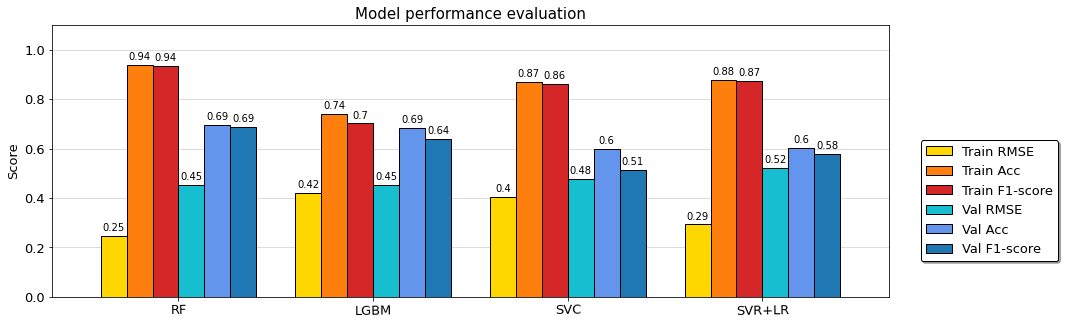

In [ ]:
# Group by metrics
train_acc = rf_train_acc, lgb_train_acc, svc_train_acc, svr_train_acc
train_rmse = rf_train_rmse, lgb_train_rmse, svc_train_rmse, svr_train_rmse
train_f1 = rf_train_f1, lgb_train_f1, svc_train_f1, svr_train_f1
val_acc = rf_val_acc, lgb_val_acc, svc_val_acc, svr_val_acc
val_rmse = rf_val_rmse, lgb_val_rmse, svc_val_rmse, svr_val_rmse
val_f1 = rf_val_f1, lgb_val_f1, svc_val_f1, svr_val_f1

# Plot
metric_df = pd.DataFrame({"Train RMSE": train_rmse, "Train Acc": train_acc, "Train F1-score": train_f1,
                       "Val RMSE": val_rmse, "Val Acc": val_acc, "Val F1-score": val_f1}, 
                      index = ["RF", "LGBM", "SVC", "SVR+LR"])

ax = metric_df.plot(y=["Train RMSE", "Train Acc", "Train F1-score", "Val RMSE", "Val Acc", "Val F1-score"], 
                 ylim=(0,1.1), figsize=(15,5), fontsize=13,
                 kind="bar", zorder=3, ec ="black",
                 rot=1, width=0.8, color = ["gold", "tab:orange", "tab:red",
                                            "tab:cyan", "cornflowerblue", "tab:blue"])
# Add details
plt.title("Model performance evaluation", fontsize = 15)
plt.ylabel("Score", fontsize = 13)
plt.grid(axis="y", zorder=0, color="lightgray")  
legend = plt.legend(frameon = 1, shadow = True, bbox_to_anchor=(1.03, 0.6), fontsize=13)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
# Annotate scores on top of the bars
for p in ax.patches:
  height = p.get_height()
  ha = {'center': 'center', 'right': 'left', 'left': 'right'}
  xpos='center'
  offset = {'center': 0, 'right': 1, 'left': -1}
  ax.annotate(f"{height:.2}",
              xy=(p.get_x() + p.get_width() / 2, height),
              xytext=(offset[xpos]*3, 3),  
              textcoords="offset points",  
              ha=ha[xpos], va='bottom')
plt.savefig(f"{DIRECTORY}models_performance_{FILENAME}.png", 
            dpi = 300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

#### ROC

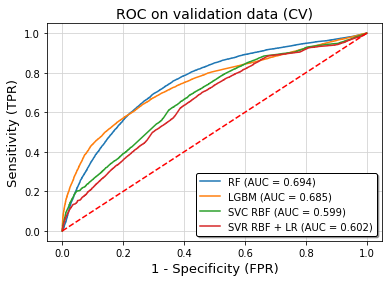

In [ ]:
# Compute AUC, FPR and TPR

def get_auc_fpr_tpr(ml_output):
  auc = roc_auc_score(ml_output["ytrue"], ml_output["ypred"])
  fpr, tpr, _ = roc_curve(ml_output["ytrue"], ml_output["yprob"])
  return auc, fpr, tpr

rf_auc, fpr_rf, tpr_rf = get_auc_fpr_tpr(rf_val_output)
lgb_auc, fpr_lgb, tpr_lgb = get_auc_fpr_tpr(lgb_val_output)
svc_auc, fpr_svc, tpr_svc = get_auc_fpr_tpr(svc_val_output)
svr_auc, fpr_svr, tpr_svr = get_auc_fpr_tpr(svr_val_output)

# Plot ROC
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.plot(fpr_rf, tpr_rf, label=f"RF (AUC = {rf_auc:.3})")
ax.plot(fpr_lgb, tpr_lgb, label=f"LGBM (AUC = {lgb_auc:.3})")
ax.plot(fpr_svc, tpr_svc, label=f"SVC RBF (AUC = {svc_auc:.3})")
ax.plot(fpr_svr, tpr_svr, label=f"SVR RBF + LR (AUC = {svr_auc:.3})")
ax.plot([0, 1], [0, 1],'r--')
plot_details(title = "ROC on validation data (CV)",
             xlabel = '1 - Specificity (FPR)', 
             ylabel = 'Sensitivity (TPR)',
             leg_loc = "lower right",
             save = True,
             filename = f"{DIRECTORY}roc_{FILENAME}")

#### Confusion matrix

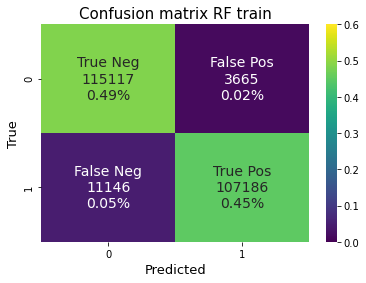

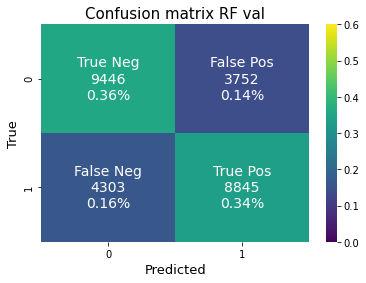

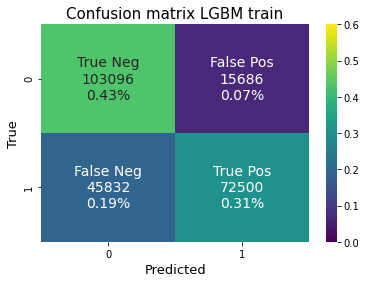

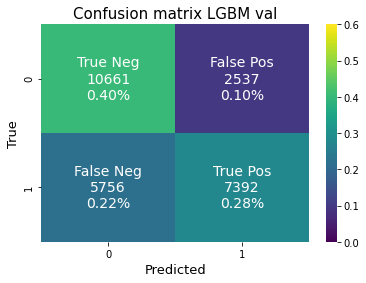

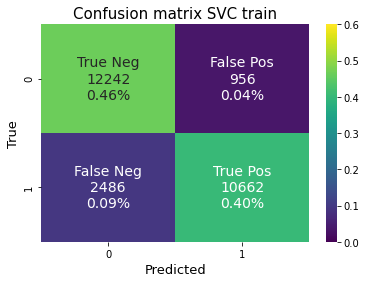

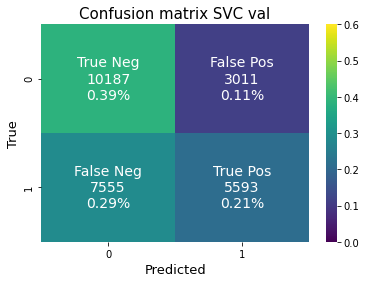

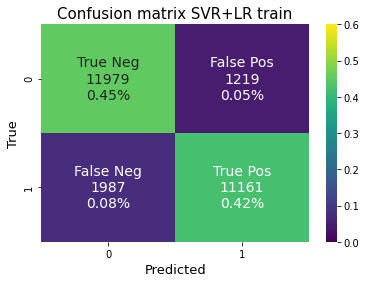

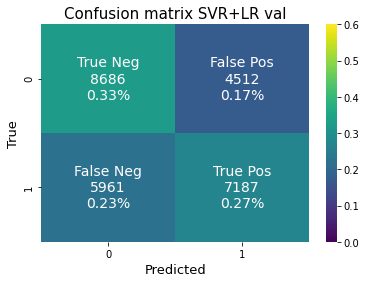

In [ ]:
def plot_confusion_matrix(ml_output, title="", vmax=0.6,
                          save=False, filename="", cmap='viridis'):
  cf_matrix = confusion_matrix(ml_output["ytrue"], ml_output["ypred"])
  group_names = ["True Neg","False Pos","False Neg","True Pos"]
  group_counts = [f"{value}" for value in cf_matrix.flatten()]
  group_percentages = [f"{value:.2f}%" for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  group_percentage_values = cf_matrix/np.sum(cf_matrix)
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(group_percentage_values, annot=labels, annot_kws={"size": 14}, 
              fmt="", vmin=0, vmax=vmax, cmap=cmap)
  plt.ylabel("True", fontsize = 13)
  plt.xlabel("Predicted", fontsize = 13)
  plt.title(f"Confusion matrix {title}", fontsize = 15)
  filename = title.replace(" ", "_")
  if save:
    plt.savefig(f"{DIRECTORY}confusion_matrix_{filename}_{FILENAME}.png", 
                dpi = 300)
  plt.show()

plot_confusion_matrix(rf_train_output, title="RF train", save=True)
plot_confusion_matrix(rf_val_output, title="RF val", save=True)

plot_confusion_matrix(lgb_train_output, title="LGBM train", save=True)
plot_confusion_matrix(lgb_val_output, title="LGBM val", save=True)

plot_confusion_matrix(svc_train_output, title="SVC train", save=True)
plot_confusion_matrix(svc_val_output, title="SVC val", save=True)

plot_confusion_matrix(svr_train_output, title="SVR+LR train", save=True)
plot_confusion_matrix(svr_val_output, title="SVR+LR val", save=True)